Moving away from `blochstate`.

In [1]:
# import all the E9 stuff
import logging
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import time
from scipy.linalg import eigh

# User defined modules
E9path = Path("C:/", "Users", "ken92", "Documents", "Studies", "E5", "simulation", "E9_simulations")
if str(E9path) not in sys.path:
    sys.path.insert(1, str(E9path))
import E9_fn.E9_constants as E9c
import E9_fn.E9_atom as E9a
import E9_fn.E9_cooltrap as E9ct
import E9_fn.plane_wave_expansion.blochstate_class as bsc
# import E9_fn.polarizabilities_calculation as E9pol
# import E9_fn.datasets.transition_line_data as TLData
from E9_fn import util

# Logging
logpath = '' # '' if not logging to a file
loglevel = logging.INFO
logroot = logging.getLogger()
list(map(logroot.removeHandler, logroot.handlers))
list(map(logroot.removeFilter, logroot.filters))
logging.basicConfig(filename = logpath, level = loglevel)

c:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\.venv\Lib\site-packages\gftool\precision.py:16: UserWarning: No quad precision datatypes available!
Some functions might be less accurate.
  warnings.warn("No quad precision datatypes available!\n"


# Inputs

In [2]:
species = "K40" # "Rb87", "K40"

# lattice parameters
V1064Er = 5.            # 1064 lattice depth, in recoil energy
V532Er = 0.             # 532 lattice depth, in recoil energy
n0nom = 0               # peak density
# The superlattice phase that determines the relative position between 1064 and 532 lattice
# 532 lattice is fixed at 0, so changing the pase by pi for 1064 restores the original lattice
phi12, phi23 = 0., 0.
# phi12, phi23 = np.pi*2/3, -np.pi*2/3    # decorated triangular lattice
ABoffset1064nom = 0     # max 0.011585 * V1064nom / 9 / np.sqrt(3) for Rb
B1_rel_int_1064 = 1     # relative intensity (field is sqrt of that) of 1064 B1
B1_rel_int_532  = 1     # relative intensity (field is sqrt of that) of 532 B1
B3_rel_int_1064 = 1     # relative intensity (field is sqrt of that) of 1064 B3
B3_rel_int_532  = 1     # relative intensity (field is sqrt of that) of 532 B3

# Basic simulation parameters
num = 6             # size of q-momentum space we consider: (-num, num) (usually 5)
k_center = (0, 0)
bandstart = 0       # starting from 0, inclusive
bandend = 5         # inclusive
qverts_str = 'E9c.Kp/E9c.k_lw, E9c.Kp2/E9c.k_lw, E9c.Kp3/E9c.k_lw, E9c.Kp4/E9c.k_lw, E9c.Kp5/E9c.k_lw, E9c.Kp6/E9c.k_lw, E9c.Kp/E9c.k_lw'
x_ticklist = ["K'", '$\Gamma$', 'K', 'M', '$\Gamma$']

# Initialization
## Units

In [3]:
if species == "Rb87":
    all_units_dict = E9c.all_lat_unit_Rb87
    Er_1064 = E9c.E_r1064_Rb87
    Er_532 = E9c.E_r532_Rb87
elif species == "K40":
    all_units_dict = E9c.all_lat_unit_K40
    Er_1064 = E9c.E_r1064_K40
    Er_532 = E9c.E_r532_K40
else:
    raise ValueError("Unknown species: {}".format(species))
m_unit = all_units_dict["m_unit"]
l_unit = all_units_dict["l_unit"]
E_unit = all_units_dict["E_unit"]
f_unit = all_units_dict["f_unit"]
t_unit = all_units_dict["t_unit"]

V532nom = V532Er * Er_532 / E9c.hnobar / 1e3       # in kHz (i.e. V_SI / hbar / 1e3 / 2pi), assuming that polarizability is accounted for correctly
V1064nom = V1064Er * Er_1064  / E9c.hnobar / 1e3   # Note that setting this to 0 doesn't give you a proper band structure of 532 nm lattice, since you are now
                                # considering too many plane waves that don't actually contribute.
V532 = 2 * np.pi * V532nom * 1e3 / f_unit   # 2 * np.pi because I have f = E/hbar instead of E/h as normally defined
V1064 = 2 * np.pi * V1064nom * 1e3 / f_unit
ABoffset1064 = 2 * np.pi * ABoffset1064nom * 1e3 / f_unit
n0 = n0nom * l_unit**3

In [4]:
Exp_lib = {"species": species, "units_dict": all_units_dict
        , 'V532nom': V532nom, 'V1064nom': V1064nom, 'V532': V532, 'V1064': V1064
        , 'B1_rel_int_532': B1_rel_int_532, 'B1_rel_int_1064': B1_rel_int_1064 , 'B3_rel_int_532': B3_rel_int_532, 'B3_rel_int_1064': B3_rel_int_1064
        , 'n0nom': n0nom, 'n0': n0
        , 'ABoffset1064nom': ABoffset1064nom, 'ABoffset1064': ABoffset1064
        , 'phi12': phi12, 'phi23': phi23}

size = 2 * num + 1
bandnum = bandend - bandstart + 1 # number of bands interested in
qverts_arr = eval(qverts_str)

# Real space plots

Pretty sure that the orientation is still wrong - maybe flipped about $x = 0$?

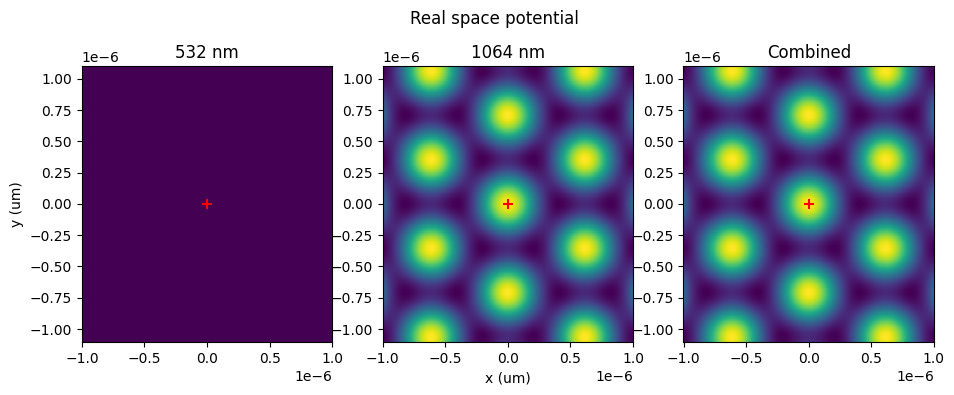

In [5]:
x_real = np.linspace(-1, 1, 500) * 1e-6
y_real = np.linspace(-1.1, 1.1, 500) * 1e-6

pos_delta = E9c.a_lw_hex * E9c.k1k * (phi12 / 2 / np.pi) + E9c.a_lw_hex * E9c.k3k * (phi23 / 2 / np.pi)
x_delta, y_delta = pos_delta # should be simple functions of phi12 and phi23
V_532_real = bsc.get_Vin(x_real, y_real, V532, B1_rel_int_532, B3_rel_int_532, 0, 0, 1)
V_1064_real = - bsc.get_Vin(x_real, y_real, V1064, B1_rel_int_1064, B3_rel_int_1064, x_delta, y_delta, 2)
V_super_real = V_532_real + V_1064_real
fig_real = plt.figure(figsize = (11, 4))
ax_532 = fig_real.add_subplot(131, aspect = "equal")
ax_1064 = fig_real.add_subplot(132, aspect = "equal")
ax_super = fig_real.add_subplot(133, aspect = "equal")
fig_real.suptitle("Real space potential")
ax_532.set_ylabel("y (um)")
ax_1064.set_xlabel("x (um)")

for ax, V_real, ax_title in zip([ax_532, ax_1064, ax_super],
                                [V_532_real, V_1064_real, V_super_real],
                                ["532 nm", "1064 nm", "Combined"]):
    im = ax.pcolormesh(x_real, y_real, V_real, cmap = 'viridis')
    ax.scatter(0, 0, color = 'red', marker = '+', s = 50)
    ax.set_title(ax_title)
    # fig_real.colorbar(im, ax = ax)
    

# Finding Bloch states and band energies

Total number of points = 1047
--- 8.232433795928955 seconds ---
--- 10.104637622833252 seconds ---


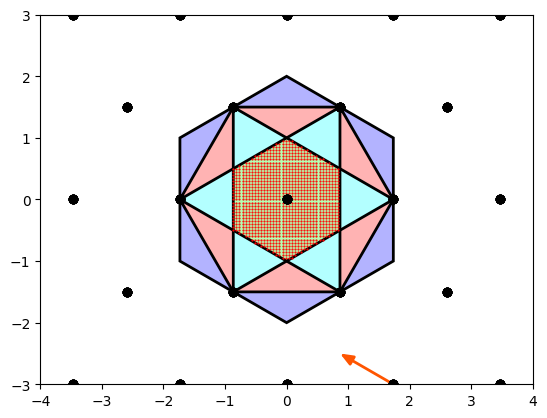

In [6]:
start_time = time.time()

# Generate qset
dq = 0.05
qsets = bsc.FindqArea(qverts_arr, dqx = dq, dqy = dq)
print("Total number of points = {0}".format(len(qsets)))
PlotBZinput = (qverts_str, qsets)
ax_BZ = bsc.PlotBZSubplot()
bsc.plot_qset(ax_BZ, qset = PlotBZinput)

# find non-interacting solution
e_values = np.zeros((len(qsets), bandnum), dtype = np.cdouble)
e_states = np.zeros((len(qsets), size**2, bandnum), dtype = np.cdouble)

Hq_mmat, Hq_nmat, H_532, H_1064 = bsc.find_H_components(num, Exp_lib, center = k_center)
for i in range(len(qsets)):
    H = bsc.find_H(qsets[i], Exp_lib, Hq_mmat, Hq_nmat, H_532, H_1064)
    assert util.IsHermitian(H)
    e_values[i,:], e_states[i,:,:] = eigh(H, eigvals = (bandstart, bandend),
                                          overwrite_a = True, check_finite = False)

print("--- {0} seconds ---".format((time.time() - start_time)))
e_states_fixed = bsc.fix_gauge_2d_grid(e_states, qsets, neighbor_dist = dq * 1.5)
print("--- {0} seconds ---".format((time.time() - start_time)))

I always get a `ComplexWarning` when running `.astype(np.double)`, but if my own check doesn't raise a warning all is good.

In [7]:
if not np.all(np.isreal(e_values)):
    logging.warning('Complex eigenvalue detected. Imaginary parts are discarded.')
e_values = e_values.astype(np.double)

C:\Users\ken92\AppData\Local\Temp\ipykernel_11100\1078986975.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  e_values = e_values.astype(np.double)


## Band structure plot

Text(0.5, 0.92, '$V_{532}$ = 0.000 kHz ($0.0\\ E_r$), V1064 = 22.049 kHz ($5.0\\ E_r$)\nAB offset = 0.000 kHz, $\\phi_{12} = 0.000$, $\\phi_{23} = 0.000$')

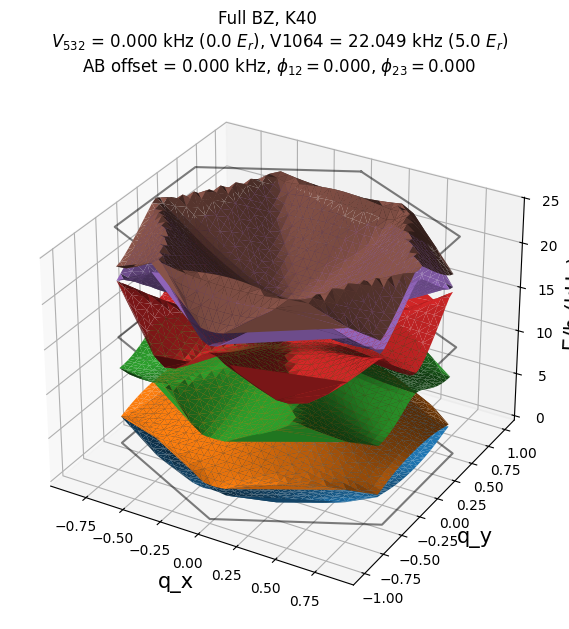

In [8]:
f2kHz = f_unit / 1e3 / (2 * np.pi) # conversion factor from natural units to kHz
E_lowest = np.min(e_values)
E_kHz_offset = (e_values - E_lowest) * f2kHz
E_kHz_highest = np.max(E_kHz_offset)
fig_E = plt.figure(0, figsize=(10,7))
fig_E.clf()
fig_E.suptitle(f"Full BZ, {species}")

ax_E = fig_E.add_subplot(111, projection = '3d')
# Add BZ boundary
bz1qx, bz1qy = [q[0] for q in E9c.BZ1_vertices], [q[1] for q in E9c.BZ1_vertices]
for i in range(3):
    ax_E.plot(bz1qx, bz1qy, np.ones_like(bz1qx) * E_kHz_highest * i / 2, '-k', alpha = 0.5)
for i in range(bandnum):
    ax_E.plot_trisurf(qsets[:, 0], qsets[:, 1], E_kHz_offset[:, i]) # TODO: try plotly
ax_E.set_xlabel('q_x', fontsize = 15)
ax_E.set_ylabel('q_y', fontsize = 15)
ax_E.set_zlabel('E/h (kHz)', fontsize = 15)

ax_E.set_title((rf'$V_{{532}}$ = {V532nom:.3f} kHz (${V532Er}\ E_r$), V1064 = {V1064nom:.3f} kHz (${V1064Er}\ E_r$)'
                '\n'
                rf'AB offset = {float(ABoffset1064nom):.3f} kHz, $\phi_{{12}} = {phi12:.3f}$, $\phi_{{23}} = {phi23:.3f}$'))

## Position of gaps at a specific frequency
The value of `alpha` is chosen to be a Gaussian centered around `f_kHz_gap_target` in gap energy (in frequency units).

In [9]:
gap_band1 = [0]
gap_band2 = [1]
f_kHz_gap_target = 3
f_kHz_gap_width = 1.
color_gap = ["r", "b"]

Text(0.5, 1.0, 'gap = 3.00$\\pm$1.0 kHz')

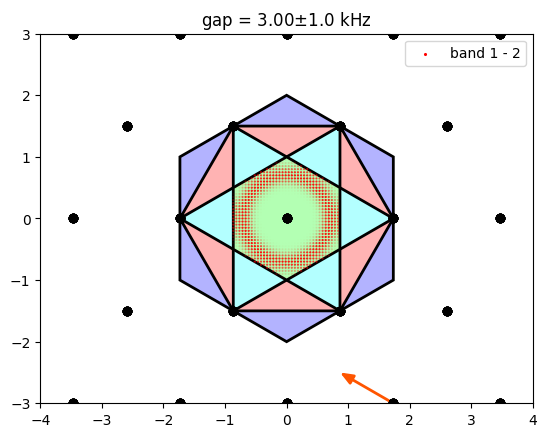

In [10]:
ax_gap = bsc.PlotBZSubplot()
for b1, b2, c in zip(gap_band1, gap_band2, color_gap):
    f_kHz_gap = E_kHz_offset[:, b2] - E_kHz_offset[:, b1]
    alpha_mask_gap = util.Gaussian_1D(f_kHz_gap, f_kHz_gap_width, f_kHz_gap_target, normalization = 'max1')
    bsc.plot_qset(ax_gap, qset = PlotBZinput, qset_kwargs = {"alpha": alpha_mask_gap, "color": c})
    ax_gap.scatter(10, 10, s = 1.5, color = c, label = f"band {b1 + 1} - {b2 + 1}") # add points outside of the plot for legend purposes
ax_gap.legend()
ax_gap.set_title((f"gap = {f_kHz_gap_target:.2f}" r"$\pm$"
                  f"{f_kHz_gap_width} kHz"))
# r_out = 24/27.71
# util.fill_annulus(ax_gap, (0, 0), 2/3 * r_out, r_out, alpha = 0.5)

# Interband Berry conections
I calculate all the connections within the given range of bands.
## Finding $A_{mn}$

In [11]:
# For example, A_01(q = qsets[i_q]) = inter_Berry_conns[i_q, 0, 1, :]
# To avoidA_10(q = qsets[i_q]) = inter_Berry_conns[i_q, 0, 1, :]
inter_Berry_conns = np.zeros((len(qsets), bandnum, bandnum, 2), dtype = np.float128)

for i in range(len(qsets)):
    for i_lower in range(bandnum):
        for i_higher in range(i_lower + 1, bandnum):
            psi1, psi2 = e_states_fixed[i, :, i_lower], e_states_fixed[i, :, i_higher]
            E12 = e_values[i, i_higher] - e_values[i, i_lower]
            inter_Berry_conns[i, i_lower, i_higher, :] = bsc.find_inter_Berry_conn(qsets[i], psi1, psi2, E12, Exp_lib, Hq_mmat, Hq_nmat)

inter_Berry_conns_mag = np.linalg.norm(inter_Berry_conns, axis = 3)

C:\Users\ken92\AppData\Local\Temp\ipykernel_11100\1270803215.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  inter_Berry_conns[i, i_lower, i_higher, :] = bsc.find_inter_Berry_conn(qsets[i], psi1, psi2, E12, Exp_lib, Hq_mmat, Hq_nmat)
C:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\E9_fn\plane_wave_expansion\blochstate_class.py:888: RuntimeWarning: divide by zero encountered in divide
  return np.einsum('a,abc,b->c', np.conj(psi2), np.stack([delx_H, dely_H], axis = 2), psi1) / E12


## Derived quantities
e.g. Matrix element of shaking

In [12]:
i_Berry = (0, 1)
theta_lin_PM = np.pi / 4
vec_PM = np.array([np.cos(theta_lin_PM), np.sin(theta_lin_PM)])

In [13]:
A_Berry = inter_Berry_conns[:, *i_Berry, :] # Interband Berry connection of the selected bands
A_mag = inter_Berry_conns_mag[:, *i_Berry]  # Magnitude of A_Berry
A_plot = A_Berry / A_mag[:, np.newaxis]     # Normalized A_Berry for the direction plot
ME2_Fermi = np.abs(A_Berry @ vec_PM)**2     # Proportional to matrix element squared

A_mag = np.nan_to_num(A_mag, nan = 0., posinf = 1.)
ME2_Fermi = np.nan_to_num(ME2_Fermi, nan = 0., posinf = 1.)

# Reconstruct grid for pcolormesh
qx = qsets[:, 0]
qy = qsets[:, 1]
qx_vals = np.unique(qx)
qy_vals = np.unique(qy)
nx = len(qx_vals)
ny = len(qy_vals)

# 2D array for |A|, initialized to 0 outside sampled region
logA_mag_grid = np.full((ny, nx), np.nan)
logME2_Fermi_grid = np.full((ny, nx), np.nan)

# Map from coordinate to grid index
qx_to_i = {val: i for i, val in enumerate(qx_vals)}
qy_to_j = {val: j for j, val in enumerate(qy_vals)}

# Fill grid at points where we have data
for k in range(len(A_mag)):
    i = qx_to_i[qx[k]]
    j = qy_to_j[qy[k]]
    logA_mag_grid[j, i] = np.log(A_mag[k])   # note: row = y, col = x
    logME2_Fermi_grid[j, i] = np.log(ME2_Fermi[k])

C:\Users\ken92\AppData\Local\Temp\ipykernel_11100\3257738921.py:3: RuntimeWarning: invalid value encountered in divide
  A_plot = A_Berry / A_mag[:, np.newaxis]     # Normalized A_Berry for the direction plot
C:\Users\ken92\AppData\Local\Temp\ipykernel_11100\3257738921.py:4: RuntimeWarning: invalid value encountered in matmul
  ME2_Fermi = np.abs(A_Berry @ vec_PM)**2     # Proportional to matrix element squared
C:\Users\ken92\AppData\Local\Temp\ipykernel_11100\3257738921.py:30: RuntimeWarning: divide by zero encountered in log
  logME2_Fermi_grid[j, i] = np.log(ME2_Fermi[k])


## Plots

In [14]:
alpha_pwr = 1 / 3
crange = 15

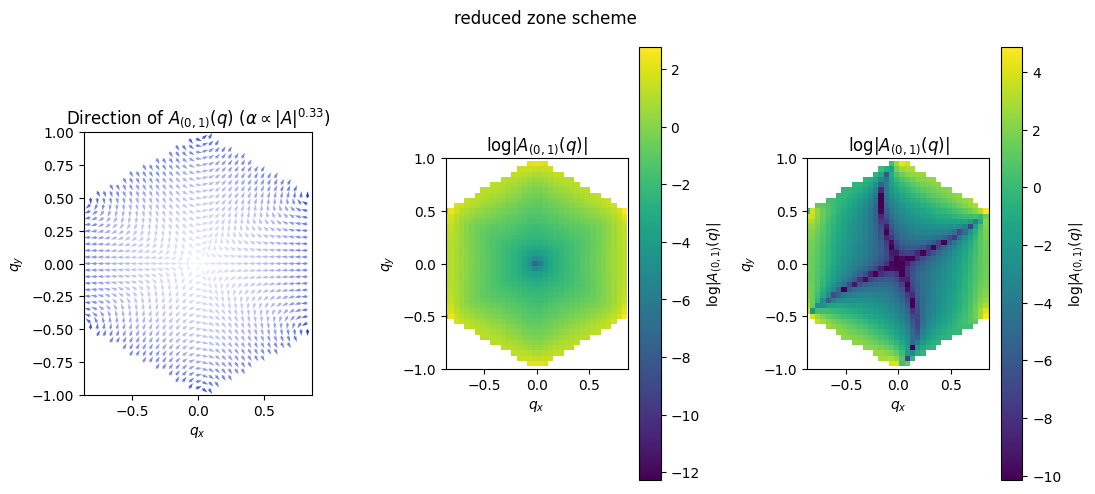

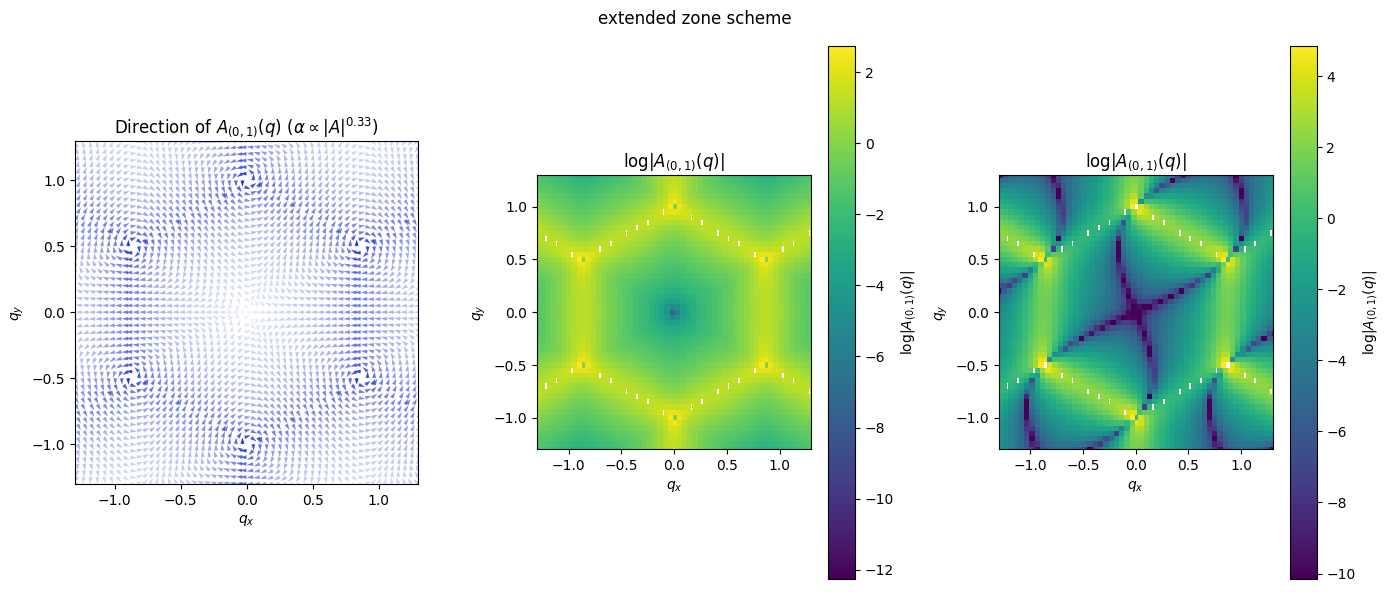

In [15]:
# Visualize A_01(q) as a vector field over the BZ
fig_Berry_reduced_BZ, axes_Berry_reduced_BZ = plt.subplots(1, 3, figsize=(11, 5))
fig_Berry_extended_BZ, axes_Berry_extended_BZ = plt.subplots(1, 3, figsize=(14, 6))

# Normalize magnitudes into [0,1] for alpha
A_mag_finite = A_mag[np.isfinite(A_mag)]
if np.nanmax(A_mag_finite) > 0:
    alpha_vals = np.nan_to_num(A_mag / A_mag_finite.max(), nan = 0., posinf = 1., neginf = 1.)
else:
    alpha_vals = np.zeros_like(A_mag)

# Vector field plots
# Build RGBA colors with alpha = amplitude
base_color = (0.1, 0.2, 0.8)  # e.g. blue-ish
colors_rgba = np.zeros((len(A_mag), 4))
colors_rgba[:, 0] = base_color[0]
colors_rgba[:, 1] = base_color[1]
colors_rgba[:, 2] = base_color[2]
colors_rgba[:, 3] = alpha_vals**alpha_pwr

quiver_scale = dq / 0.05
for ax, range_g1g, range_g2g in zip(
    [axes_Berry_reduced_BZ[0], axes_Berry_extended_BZ[0]],
    [[0], [-1, 0, 1]],
    [[0], [-1, 0, 1]],
):
    for idx_g1g in range_g1g:
        for idx_g2g in range_g2g:
            qxg = qx + idx_g1g * E9c.g1g[0] + idx_g2g * E9c.g2g[0]
            qyg = qy + idx_g1g * E9c.g1g[1] + idx_g2g * E9c.g2g[1]
            ax.quiver(
                qxg, qyg,
                A_plot[:, 0], A_plot[:, 1],
                color = colors_rgba,
                angles = 'xy', scale_units = 'xy', scale = 20 * quiver_scale,
                width = 0.005 * quiver_scale
            )
    ax.set_title(rf"Direction of $A_{{{i_Berry}}}(q)$ ($\alpha \propto |A|^{{{alpha_pwr:.2f}}}$)")

# Amplitude plots (|A| and matrix element squared)
# Make 2D coordinate grids for pcolormesh
for ax, fig, data, range_g1g, range_g2g in zip(
    [axes_Berry_reduced_BZ[1], axes_Berry_extended_BZ[1], axes_Berry_reduced_BZ[2], axes_Berry_extended_BZ[2]],
    [fig_Berry_reduced_BZ, fig_Berry_extended_BZ, fig_Berry_reduced_BZ, fig_Berry_extended_BZ],
    [logA_mag_grid, logA_mag_grid, logME2_Fermi_grid, logME2_Fermi_grid],
    [[0], [-1, 0, 1], [0], [-1, 0, 1]],
    [[0], [-1, 0, 1], [0], [-1, 0, 1]],
):
    for idx_g1g in range_g1g:
        for idx_g2g in range_g2g:
            dmax = np.nanmax(data)
            QX, QY = np.meshgrid(qx_vals + idx_g1g * E9c.g1g[0] + idx_g2g * E9c.g2g[0],
                                 qy_vals + idx_g1g * E9c.g1g[1] + idx_g2g * E9c.g2g[1], indexing='xy')
            pcm = ax.pcolormesh(
                QX, QY, data,
                shading='auto',
                cmap='viridis', clim = (dmax - crange, dmax)
            )
    ax.set_title(rf"$\log |A_{{{i_Berry}}}(q)|$")
    fig.colorbar(pcm, ax = ax, label = rf"$\log |A_{{{i_Berry}}}(q)|$")

# Repetitive stuff
for axes, xlim, ylim in zip(
    [axes_Berry_reduced_BZ, axes_Berry_extended_BZ],
    [(-np.sqrt(3)/2, np.sqrt(3)/2), (-1.3, 1.3)],
    [(-1, 1), (-1.3, 1.3)],):
        for ax in axes:
            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)
            ax.set_xlabel(r"$q_x$")
            ax.set_ylabel(r"$q_y$")
            ax.set_aspect('equal')

fig_Berry_reduced_BZ.suptitle("reduced zone scheme")
fig_Berry_extended_BZ.suptitle("extended zone scheme")
fig_Berry_reduced_BZ.tight_layout()
fig_Berry_extended_BZ.tight_layout()

## Quantum metric tensor (ignore for now)

In [16]:
bool_find_QMT = False

In [17]:
def find_q_geo_tensor(n_q, n_band, Exp_lib, q_list, E_list, psi_list, Hq_mmat, Hq_nmat, component = 'xx'):
    """Find the quantum geometric tensor for a given Bloch state psi."""
    q = q_list[n_q]
    psin = psi_list[n_q, :, n_band]
    En = E_list[n_q, n_band]
    dH1 = bsc.find_del_H(q, Exp_lib, Hq_mmat, Hq_nmat, direction = component[0])
    dH2 = bsc.find_del_H(q, Exp_lib, Hq_mmat, Hq_nmat, direction = component[1])
    qgt = 0j
    for m_band in range(E_list.shape[1]):
        if m_band == n_band:
            continue
        psim = psi_list[n_q, :, m_band]
        Em = E_list[n_q, m_band]
        qgt += psim.conj() @ dH1 @ psin * psin.conj() @ dH2 @ psim / (Em - En)**2
    if not util.IsHermitian(qgt):
        logging.warning(f"Quantum geometric tensor for n_band {n_band}, n_q {n_q} is not Hermitian")
    return qgt

In [18]:
if bool_find_QMT:
    qgts_xx = np.zeros((len(qsets), bandnum), dtype = np.cdouble)
    for i in range(len(qsets)):
        for j in range(bandnum):
            qgts_xx[i, j] = find_q_geo_tensor(i, j, Exp_lib, qsets, e_values, e_states, Hq_mmat, Hq_nmat)
    qmts_xx = np.real(qgts_xx)                # quantum metric tensor
    berry_curvs_xx = - 2 * np.imag(qgts_xx)   # Berry curvature

    fig_qgt = plt.figure(2, figsize=(10,7))
    fig_qgt.clf()
    ax_qgt = fig_qgt.add_subplot(111)
    ax_qgt.set_title('Quantum geometric tensor')
    ax_qgt.plot(xq, qmts_xx[:, 2], label = 'qmts_00')